In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [9]:
plt.rcParams['figure.figsize'] = (15, 7.5)
plt.rcParams['axes.grid'] = False

In [10]:
df = pd.read_csv('../data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


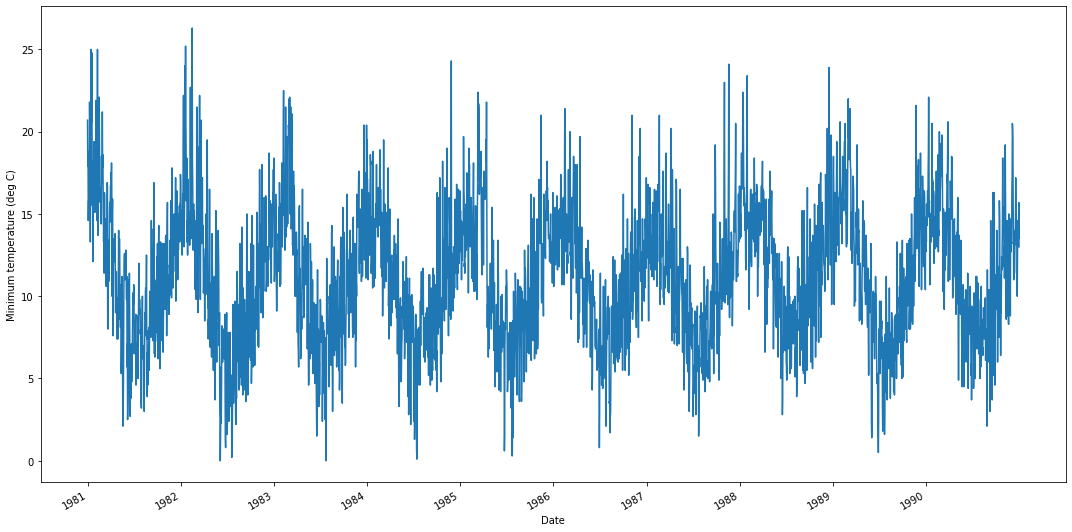

In [11]:
fig, ax = plt.subplots()

ax.plot(df['Temp'])
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

plt.xticks(np.arange(0, 3649, 365), np.arange(1981, 1991, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
df.columns = ['ds', 'y']
train = df[:-365]
test = df[-365:]
df.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [13]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-365:-360]

In [ ]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

In [ ]:
test['baseline'] = train['y'][-365:].values
test.head()

In [ ]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

test.iloc[59]

In [ ]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(
    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
fig1 = m.plot(forecast)

In [14]:
fig2 = m.plot_components(forecast)

NameError: name 'forecast' is not defined

In [15]:
from fbprophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

NameError: name 'forecast' is not defined

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

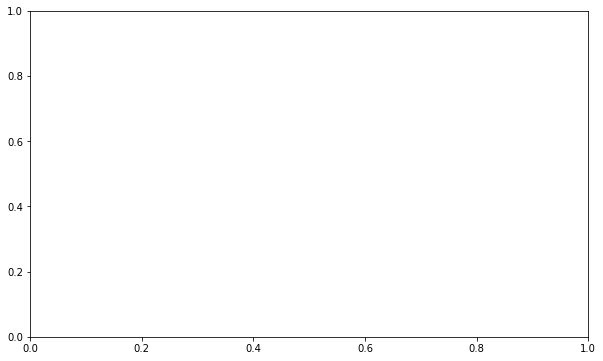

In [16]:
from fbprophet.plot import plot_yearly, plot_weekly

fig4 = plot_yearly(m)

In [ ]:
fig5 = plot_weekly(m)

In [ ]:
m2 = Prophet(yearly_seasonality=20).fit(train)
fig6 = plot_yearly(m2)

In [ ]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

df_cv.head()

In [17]:
from fbprophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv, rolling_window=0)

df_perf.head()

NameError: name 'df_cv' is not defined

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

fig7 = plot_cross_validation_metric(df_cv, metric='mae')

In [18]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
best_params = all_params[np.argmin(maes)]
print(best_params)

In [19]:
df = pd.read_csv('../data/monthly_chocolate_search_usa.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/monthly_chocolate_search_usa.csv'

KeyError: 'chocolate'

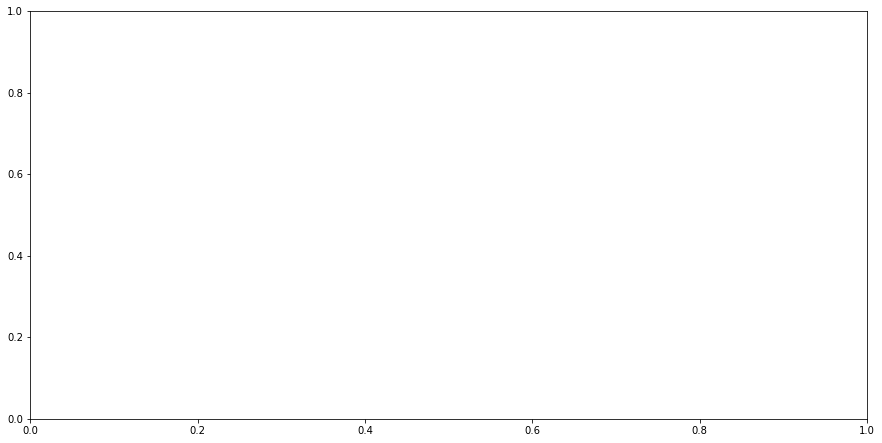

In [20]:
fig, ax = plt.subplots()

ax.plot(df['chocolate'])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df.columns = ['ds', 'y']
df.head()

In [ ]:
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

In [ ]:
train = df[:-12]
test = df[-12:]
train.tail()

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

cutoffs = pd.date_range(start='2009-01-31', end='2020-01-31', freq='12M')

for param in params:
    m = Prophet(**param)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

In [ ]:
best_params = params[np.argmin(mses)]
print(best_params)

In [ ]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.fit(train)

In [ ]:
future = m.make_future_dataframe(periods=12, freq='M')

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

NameError: name 'future' is not defined

In [22]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

NameError: name 'forecast' is not defined

In [ ]:
test['baseline'] = train['y'][-12:].values
test.head()

In [23]:
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

NameError: name 'mean_absolute_error' is not defined

KeyError: 'baseline'

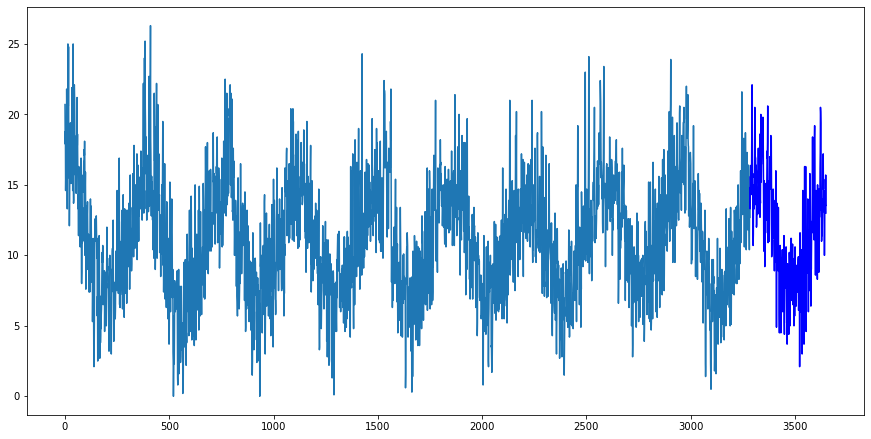

In [24]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

ax.axvspan(204, 215, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(180, 215)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
prophet_components_fig = m.plot_components(forecast)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [ ]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

In [ ]:
SARIMA_model = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [25]:
residuals = SARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)
test

NameError: name 'SARIMA_model_fit' is not defined

In [ ]:
SARIMA_pred = SARIMA_model_fit.get_prediction(204, 215).predicted_mean
test['SARIMA_pred'] = SARIMA_pred
test

In [26]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])
print(SARIMA_mae)

NameError: name 'mean_absolute_error' is not defined